# Extracting Tregs from a HTAN scRNAseq dataset.

## 1. Set up libraries

In [1]:
# If using google colab include the following install; otherwise skip if you have scanpy installed:
!pip install scanpy
!pip install celltypist

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.7/141.7 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 11.3 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=e9633f1d810b357e67b2b8c0b35210f744676229c79c277c1f126f3ccf016f75
  Stored in directory: /home/jovyan/.cache/pip/wheels/4e/56/35/a748fc57279a4b84d0b332879445fed1ad8478e7257986b015
Successfully built session-info
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 89.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━

In [5]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scanpy as sc
import scipy
from scipy.sparse import csr_matrix
import celltypist
from celltypist import models
import os

## 2. QC

In [7]:
## Define input output file paths
dir='/sbgenomics/project-files/'
file_name="adata.immune.SCLC_samples_only.010920"
input_path= os.path.join(dir, f"{file_name}.h5ad")
out_tcells_path = os.path.join(dir, f"{file_name}_tcells.h5ad")
out_tregs_path = os.path.join(dir, f"{file_name}_tregs.h5ad")


In [10]:
# load input data
adata= sc.read_h5ad(input_path)

In [11]:
adata

AnnData object with n_obs × n_vars = 16475 × 19412
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'mito_frac', 'RBP_frac', 'batch', 'patient', 'tissue', 'treatment', 'procedure', 'cell_type', 'cell_type_broad', 'clusters', 'treatment_categorized', 'subtype', 'H_treatment', 'H_subtype'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    layers: 'log2(X+0.1)', 'normalized'
    obsp: 'connectivities', 'distances'

In [12]:
# compute fraction of mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.obs['mito_frac'] = adata.obs['pct_counts_mt'] / 100
print(adata.obs[['mito_frac']].head())

                                 mito_frac
Cell                                      
RU1311A_T_1_165945547864806            0.0
PleuralEffusion_235007433161052        0.0
RU779D_231906420612515                 0.0
RU1145_133982151621558                 0.0
RU779D_236700571186918                 0.0


count    16475.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: mito_frac, dtype: float64

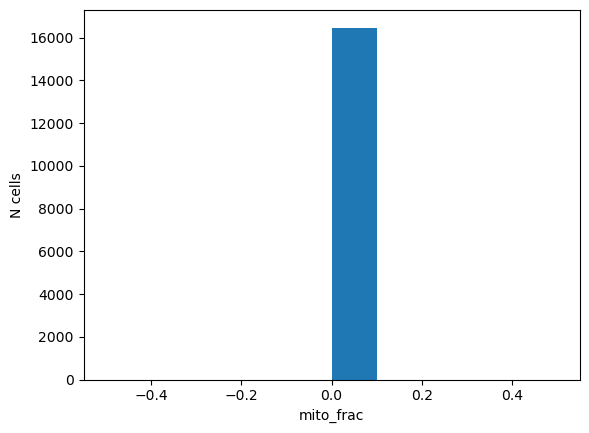

In [14]:
# Filtering and QC
plt.hist(adata.obs['mito_frac'])
plt.xlabel('mito_frac')
plt.ylabel('N cells')
pd.DataFrame.describe(adata.obs['mito_frac'])

We can see from this data that the authors already filtered cells with mito_frac > 20% (as mentioned in the manuscript).



count    16475.000000
mean      3342.321533
std       1080.024048
min        442.583954
25%       2740.809326
50%       3455.297119
75%       4063.716309
max       6596.659668
Name: total_counts, dtype: float64

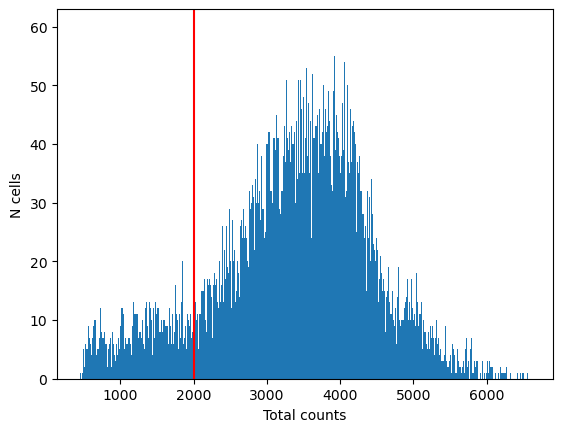

In [15]:
#plot histogram of number of counts per cell
plt.hist(adata.obs['total_counts'], bins=1000)
plt.xlabel('Total counts')
plt.ylabel('N cells')
plt.axvline(2000, color='red')
#plt.xlim(0,1e3) just to take a look if there was filtering around 0 counts per cell
pd.DataFrame.describe(adata.obs['total_counts'])


From the plot and the statistics, we can infer that cell filtering, where true cells are distinguished from empty droplets based on the cumulative distribution of total molecule count, used a threshold of 100 for total counts.

count    16475.000000
mean      1310.657360
std        821.622087
min         61.000000
25%        797.000000
50%       1193.000000
75%       1646.000000
max       7248.000000
Name: n_genes_by_counts, dtype: float64

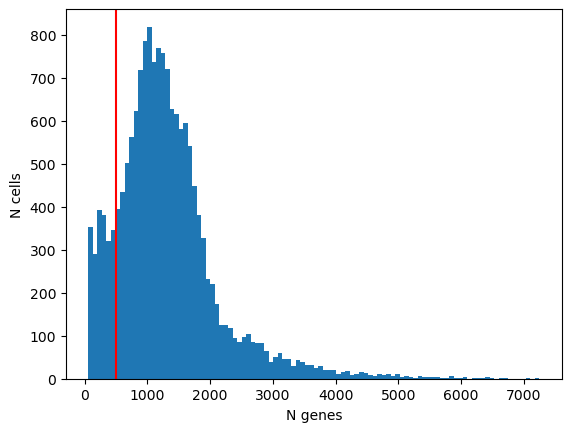

In [16]:
#plot histogram of number of unique genes by cells
plt.hist(adata.obs['n_genes_by_counts'], bins=100)
plt.xlabel('N genes')
plt.ylabel('N cells')
plt.axvline(500, color='red')
#plt.xlim(0,4e3)
pd.DataFrame.describe(adata.obs['n_genes_by_counts'])

From the plot and the statistics, we can infer that cells with low library complexity are filtered (cells that express very few unique genes) using a threshold of 70 for number of genes expressed by a cell.

So, it appears that we already have a file with data that went through pre-processing. No further filtering will be made to the original file.

## 3. Data Normalization and Log-transformation

Now that filtering has been assessed, the next step before using the CellTypist library is normalization. In order to call cells, the expression matrix must be pre-processed (and is required) as log1p normalised expression to 10,000 counts per cell.

So, we call the following functions:

In [17]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

We also run PCA and UMAP from the scanpy library for visualization:

In [18]:
sc.tl.pca(adata, svd_solver='arpack')

In [19]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [20]:
sc.tl.umap(adata)

In order to check the previous steps we've implemented, let's plot the UMAP we've generated. In this case, the authors have already provided cell type labels. We can see them plotted below. This will be used as a means of comparison to cell typist predictions.

We can see distinct clusters of cell types! Therefore, we're ready to move on to the final step.

## 4. Implementation of CellTypist

CellTypist is an open source tool for automated cell type annotations as well as a working group in charge of curating models and ontologies. More information can be found at https://www.celltypist.org/. They also have a detailed tutorial which can be helpful if it's your first time using this library: https://colab.research.google.com/github/Teichlab/celltypist/blob/main/docs/notebook/celltypist_tutorial_ml.ipynb#scrollTo=passive-arrest

As discussed previously, the cells in this dataset are a subset of only immune small cell lung cancer. Therefore, the model used here is the low resolution immune cell model.

This model is was built from immune sub-populations combined from 20 tissues of 18 studies. More details can be found: https://www.celltypist.org/models

In [22]:
#The model name refers to the grouping - thus, high means low resolution (less cell categories)
model = models.Model.load(model = 'Immune_All_High.pkl')

🔎 No available models. Downloading...
📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 52
📂 Storing models in /home/jovyan/.celltypist/data/models
💾 Downloading model [1/52]: Immune_All_Low.pkl
💾 Downloading model [2/52]: Immune_All_High.pkl
💾 Downloading model [3/52]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/52]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/52]: Adult_Human_MTG.pkl
💾 Downloading model [6/52]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [7/52]: Adult_Human_PrefrontalCortex.pkl
💾 Downloading model [8/52]: Adult_Human_Skin.pkl
💾 Downloading model [9/52]: Adult_Mouse_Gut.pkl
💾 Downloading model [10/52]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [11/52]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [12/52]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [13/52]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [14/52]: COVID19_HumanChallenge_Blood.pkl
💾 Downloadin

In [23]:
# Additionally, model information can be found by just checking the model variable:
model

CellTypist model with 32 cell types and 6639 features
    date: 2022-07-16 08:53:00.959521
    details: immune populations combined from 20 tissues of 18 studies
    source: https://doi.org/10.1126/science.abl5197
    version: v2
    cell types: B cells, B-cell lineage, ..., pDC precursor
    features: A1BG, A2M, ..., ZYX

In [24]:
# This is also true for model cell types:
model.cell_types

array(['B cells', 'B-cell lineage', 'Cycling cells', 'DC', 'DC precursor',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ETP',
       'Early MK', 'Endothelial cells', 'Epithelial cells',
       'Erythrocytes', 'Erythroid', 'Fibroblasts', 'Granulocytes',
       'HSC/MPP', 'ILC', 'ILC precursor', 'MNP', 'Macrophages',
       'Mast cells', 'Megakaryocyte precursor',
       'Megakaryocytes/platelets', 'Mono-mac', 'Monocyte precursor',
       'Monocytes', 'Myelocytes', 'Plasma cells', 'Promyelocytes',
       'T cells', 'pDC', 'pDC precursor'], dtype=object)

Using the model to predict the cell types is accomplished with the following line. Here, there are several arguments for cell calling thresholds which are described in detail within the CellTypist documentation.

In [25]:
predictions=celltypist.annotate(adata, model = model, mode = 'best match', p_thres = 0.5, majority_voting = True)

🔬 Input data has 16475 cells and 19412 genes
🔗 Matching reference genes in the model
🧬 5294 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [26]:
# Add the predictions to our main dataset
adata = predictions.to_adata()

In [27]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
Cell,,,
RU1311A_T_1_165945547864806,T cells,16,T cells
PleuralEffusion_235007433161052,ILC,41,ILC
RU779D_231906420612515,T cells,23,T cells
RU1145_133982151621558,T cells,45,T cells
RU779D_236700571186918,T cells,11,T cells
...,...,...,...
RU1145_157536929573171,ILC,45,T cells
RU1145_161890937236718,pDC,119,pDC
PleuralEffusion_131097900824419,ILC,22,ILC


Now we can see that we've successfully used CellTypist to annotate the data.

## 5. Create Plots with Predictions 

Lastly, we want to compare the author cell labels to those produced by CellTypist. Additionally, we are interested in the cell label score. In order to compare these outputs, we plot UMAPs of the original author-generated, broad cell types side-by-side to those generated by CellTypist.

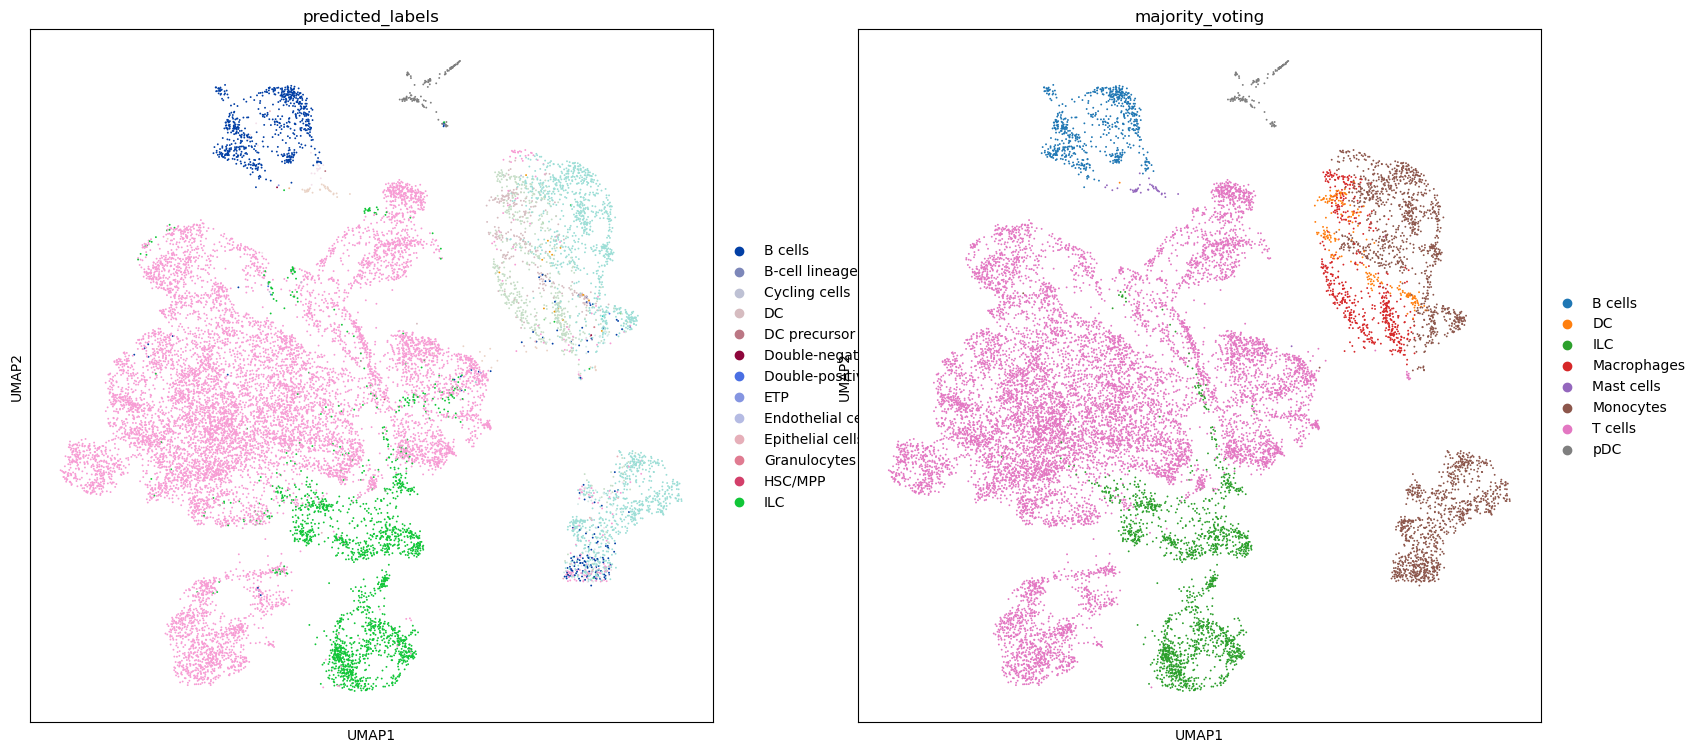

In [28]:
plt.rcParams['figure.figsize'] = (9, 9)
sc.pl.umap(adata, color = ["predicted_labels", "majority_voting"])


## 6. Filter for Tregs

In [30]:
# Filter out T cells
adata_tcells = adata[adata.obs["majority_voting"]== "T cells"]

In [31]:
adata_tcells

View of AnnData object with n_obs × n_vars = 11082 × 19412
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'mito_frac', 'RBP_frac', 'batch', 'patient', 'tissue', 'treatment', 'procedure', 'cell_type', 'cell_type_broad', 'clusters', 'treatment_categorized', 'subtype', 'H_treatment', 'H_subtype', 'total_counts_mt', 'pct_counts_mt', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'neighbors', 'log1p', 'pca', 'umap', 'over_clustering', 'predicted_labels_colors', 'majority_voting_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log2(X+0.1)', 'normalized'
    obsp: 'connectivities', 'distances'

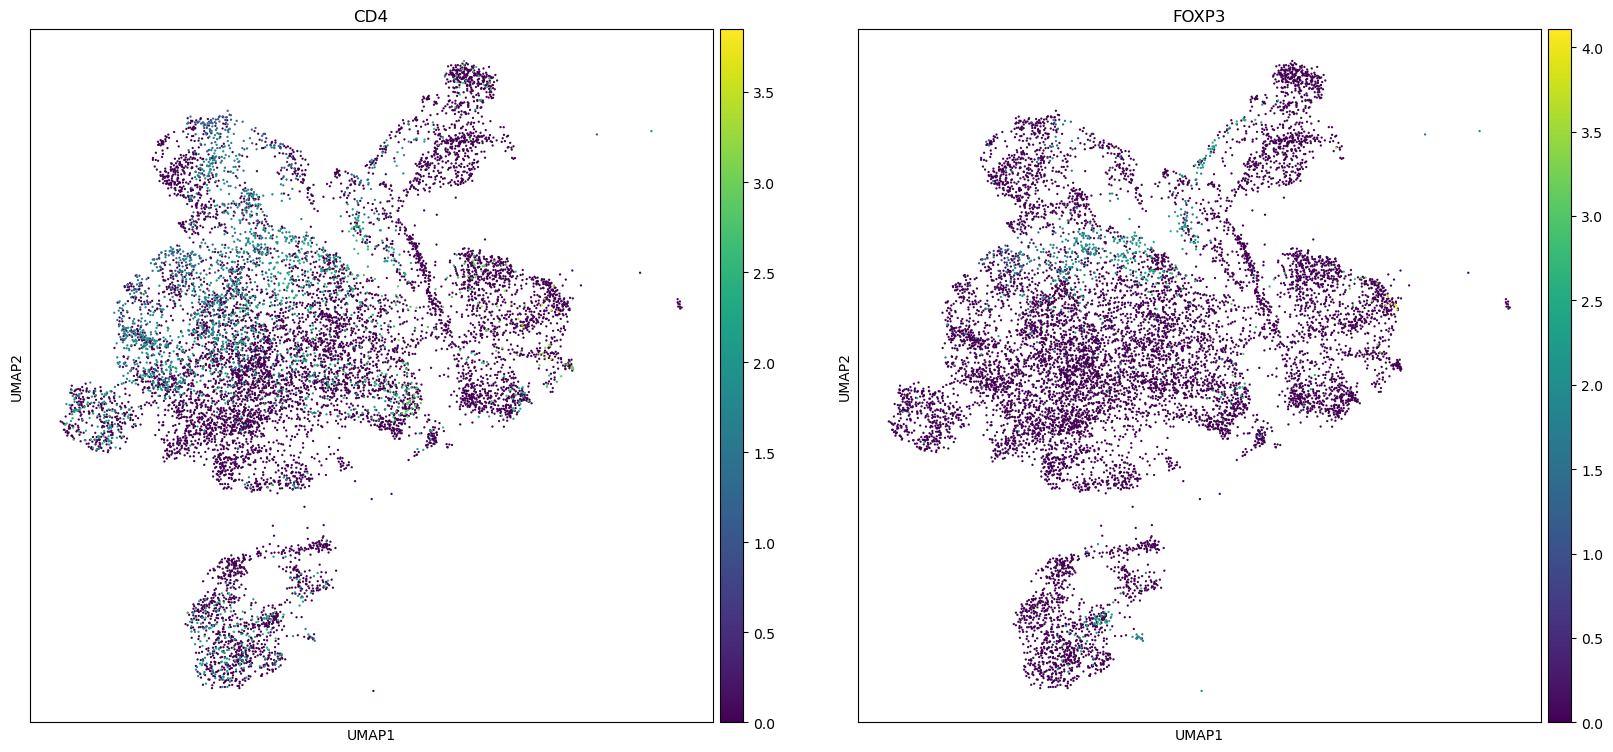

In [32]:
sc.pl.umap(adata_tcells, color = ["CD4", "FOXP3"], cmap='viridis')


In [33]:
# Filter out Tregs
gene_cd4 = "CD4"
gene_foxp3 = "FOXP3"

# Ensure that the genes are present in the dataset
if gene_cd4 in adata_tcells.var_names and gene_foxp3 in adata_tcells.var_names:
    # Create a boolean mask for cells with more than 1 count for both CD4 and FOXP3
    mask = (adata_tcells[:, gene_cd4].X > 1).flatten() & (adata_tcells[:, gene_foxp3].X > 1).flatten()

    # Filter adata based on the mask
    adata_tregs = adata_tcells[mask].copy()

    # Check the result
    print(f"Number of cells with more than 1 count for both CD4 and FOXP3: {adata_tregs.n_obs}")
else:
    print("One or both of the genes (CD4, FOXP3) are not present in the dataset.")


Number of cells with more than 1 count for both CD4 and FOXP3: 301


In [70]:
adata_tcells.write(out_tcells_path)

In [71]:
adata_tregs.write(out_tregs_path)